In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import math
import csv

In [2]:
#IDPH put a row of non-data at the very top of their csv, reading it in
#without pandas to skip the first row before putting it in a dataframe

with open('IDPHExport.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=",")

    metadata = next(csvreader)
    header = next(csvreader)
    data = pd.DataFrame(columns=header)
    for row in csvreader:
        to_append = pd.Series(row, index = data.columns)
        data = data.append(to_append, ignore_index=True)

In [3]:
metadata

['Data is Provisional and subject to change. Data presented is reported as of 3/10/2021']

In [4]:
data["Report_Date"] = pd.to_datetime(data["Report_Date"])
data = data.astype({'AdministeredCount': 'int64', 'AdministeredCountChange': 'int64', 'PersonsFullyVaccinated': 'int64'})

In [5]:
data = data[['AdministeredCount', 'AdministeredCountChange','PersonsFullyVaccinated', 'Report_Date']]



In [6]:
data = data.rename(columns={'AdministeredCount':'total doses to date',
                     'AdministeredCountChange':'daily new doses',
                     'PersonsFullyVaccinated':'total people with two doses', 
                     'Report_Date': "date"})

In [7]:
data.dtypes

total doses to date                     int64
daily new doses                         int64
total people with two doses             int64
date                           datetime64[ns]
dtype: object

In [8]:
# calculating new second doses from change in total people with two doses and new first doses
# from total new doses and new second doses

for index, row in data.iterrows():
    if index == 0:
        data.loc[index, "new second doses"] = 0
    else:
        previous = index - 1
        data.loc[index, "new second doses"] = data.loc[index, "total people with two doses"] - data.loc[previous, "total people with two doses"]
    
    data.loc[index, "new first doses"] = data.loc[index, "daily new doses"] - data.loc[index, "new second doses"]
    

In [9]:
data["new second doses"] = data["new second doses"].astype("int64")
data["new first doses"] = data["new first doses"].astype("int64")

In [10]:
#rolling averages

data["first dose 7 day rolling average"] = data.rolling(window=7, on="date", min_periods=1)["new first doses"].mean()
data["second dose 7 day rolling average"] = data.rolling(window=7, on="date")["new second doses"].mean()


In [11]:
#xticks = every 7 days starting at the first date
xticks=[]
date_list = data["date"].tolist()
x = date_list[0]

while x in date_list:
    xticks.append(x.strftime('%m/%d'))
    x = x+timedelta(days=7)

In [12]:
#while x in date_list:
   # xticks.append(x.strftime('%m/%d'))
   # x = x+timedelta(days=7)

In [13]:
#yticks = every 10k, going one past the highest y value
max_y = data[["new first doses", "new second doses"]].max().max()
max_ytick = int(math.ceil(max_y / 10000)) * 10000
yticks = np.arange(10000, max_ytick+1, 10000)
ytick_labels = [f"{int(y/1000)}k" for y in yticks]

In [14]:
ytick_labels

['10k', '20k', '30k', '40k', '50k', '60k', '70k', '80k']

In [15]:
bars1 = data["new first doses"]
bars2 = data["new second doses"]

barwidth = .5

r1 = np.arange(len(bars1))
r2 = [x + barwidth for x in r1]
#bars2 shifted over by the width of a bar

In [16]:
# 2nd dose rolling average shifted over to display above the 2nd dose bars, not display until
# it gets above zero

r_2ndrolling = np.arange(22.5,len(bars1)+.5)
data_2ndrolling = data["second dose 7 day rolling average"].drop(np.arange(22))

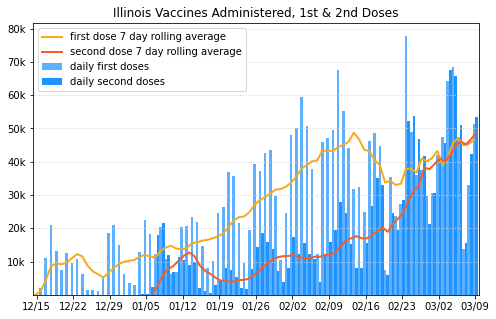

In [17]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

plt.grid(True, color = "#D3D3D3", axis='y', linewidth = "1", linestyle=':')
plt.title("Illinois Vaccines Administered, 1st & 2nd Doses")

plt.bar(r1, bars1, color='#5CB0FF', width=barwidth, label='daily first doses')
plt.bar(r2, bars2, color='#1F93FF', width=barwidth, label='daily second doses')

plt.plot(r1, data["first dose 7 day rolling average"], linewidth=2, color='#F6AA1C', label = "first dose 7 day rolling average")
plt.plot(r_2ndrolling, data_2ndrolling, linewidth=2, color='#F65F28', label = "second dose 7 day rolling average")

plt.xticks([r*7 + (barwidth/2) for r in range(len(xticks))], xticks)
plt.yticks(yticks, ytick_labels)
plt.xlim(-.5,max(r1)+1)

plt.legend()
plt.savefig("vaccines.png")
plt.show()

In [20]:
data["first dose 7 day rolling average"].iloc[-1]

46613.57142857143

In [21]:
data["second dose 7 day rolling average"].iloc[-1]

48755.857142857145